In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

#  06. Convolutional Neural Networks
In earlier chapters, we came up against image data, for which each example consists of a 2D grid of pixels. Depending on whether we're handling black-and-white or color images, each pixel location might be associated with either one or multiple numerical values, respectively. Until now, our way of dealing with this rich structure was deeply unsatisfying. We simply discarded each image's spatial structure by flattening them into 1D vectors, feeding them through a (fully connected) MLP. Because these networks invariant to the order of the features we could get similar results regardless of whether we preserve an order corresponding to the spatial structure of the pixels or if we permute the columns of our design matrix before fitting the MLP's parameters. Preferably, we would leverage our prior knowledge that nearby pixels are typically related to each other, to build efficient models for learning from image data.

This chapter introduces convolutional neural networks (CNNs), a powerful family of neural networks that were designed for precisely this purpose. CNN-based architectures are now ubiquitous in the field of computer vision, and have become so dominant that hardly anyone today would develop a commercial application or enter a competition related to image recognition, object detection, or semantic segmentation, without building off of this approach.

Modern ConvNets, as they are called colloquially owe their design to inspirations from biology, group theory, and a healthy dose of experimental tinkering. In addition to their sample efficiency in achieving accurate models, convolutional neural networks tend to be computationally efficient, both because they require fewer parameters than dense architectures and because convolutions are easy to parallelize across GPU cores. Consequently, practitioners often apply CNNs whenever possible, and increasingly they have emerged as credible competitors even on tasks with 1D sequence structure, such as audio, text, and time series analysis, where recurrent neural networks are conventionally used. Some clever adaptations of CNNs have also brought them to bear on graph-structured data and in recommender systems.

First, we will walk through the basic operations that comprise the backbone of all convolutional networks. These include the convolutional layers themselves, nitty-gritty details including padding and stride, the pooling layers used to aggregate information across adjacent spatial regions, the use of multiple channels (also called filters) at each layer, and a careful discussion of the structure of modern architectures. We will conclude the chapter with a full working example of `LeNet`, the first convolutional network successfully deployed, long before the rise of modern deep learning. In the next chapter, we will dive into full implementations of some popular and comparatively recent CNN architectures whose designs represent most of the techniques commonly used by modern practitioners.

## 6.1 From Dense Layers to Convolutions
The models that we have discussed so far remain (to this day) appropriate options when we are dealing with tabular data. By tabular, we mean that the data consists of rows corresponding to examples and columns corresponding to features. With tabular data, we might anticipate that the patterns we seek could involve interactions among the features, but we do not assume any structure a priori concerning how the features interact.

Sometimes, we truly lack knowledge to guide the construction of craftier architectures. In these cases, a multilayer perceptron may be the best that we can do. However, for high-dimensional perceptual data, these structure-less networks can grow unwieldy.

For instance, let's return to our running example of distinguishing cats from dogs. Say that we do a thorough job in data collection, collecting an annotated dataset of 1-megapixel photographs. This means that each input to the network has 1 million dimensions. Even an aggressive reduction to 1,000 hidden dimensions would require a dense (fully connected) layer characterized by $10^9$ parameters. Unless we have lots of GPUs, a talent for distributed optimization, and an extraordinary amount of patience, learning the parameters of this network may turn out to be infeasible.

A careful reader might object to this argument on the basis that 1 megapixel resolution may not be necessary. However, while we might be able to get away with 100,000 pixels, our hidden layer of size $1000$ grossly underestimated the number of hidden nodes that it takes to learn good representations of images, so a practical system will still require billions of parameters. Moreover, learning a classifier by fitting so many parameters might require collecting an enormous dataset. And yet today both humans and computers are able to distinguish cats from dogs quite well, seemingly contradicting these intuitions. That is because images exhibit rich structure that can be exploited by humans and machine learning models alike. Convolutional neural networks are one creative way that machine learning has embraced for exploiting some of the known structure in natural images.

### 6.1.1 Invariances
Imagine that you want to detect an object in an image. It seems reasonable that whatever method we use to recognize objects should not be overly concerned with the precise location of the object in the image. Ideally, our system should exploit this knowledge. Pigs usually do not fly and planes usually do not swim. Nonetheless, we should still recognize a pig were one to appear at the top of the image. We can draw some inspiration here from the children's game 'Where's Waldo' (depicted in `Fig. 6.1.1`). 

<img src="images/06_01.jpg" style="width:700px;"/>

The game consists of a number of chaotic scenes bursting with activity. Waldo shows up somewhere in each, typically lurking in some unlikely location. The reader's goal is to locate him. Despite his characteristic outfit, this can be surprisingly difficult, due to the large number of distractions. However, what Waldo looks like does not depend upon where Waldo is located. We could sweep the image with a Waldo detector that could assign a score to each patch, indicating the likelihood that the patch contains Waldo. CNNs systematize this idea of spatial invariance, exploiting it to learn useful representations with few parameters.

We can now make these intuitions more concrete by enumerating a few desiderata to guide our design of a neural network architecture suitable for computer vision:
1. In the earliest layers, our network should respond similarly to the same patch, regardless of where it appears in the image (translation invariance).
2. The earliest layers of the network should focus on local regions, without regard for the contents of the image in distant regions (locality). Eventually, these local representations can be aggregated to make predictions at the whole image level.

Let us see how this translates into mathematics.

### 6.1.2 Constraining the MLP
To start off, we can consider an MLP with $h \times w$ images as inputs (represented as matrices in math, and as 2D arrays in code), and hidden representations **similarly organized as** $h \times w$ **matrices / 2D arrays**. Let that sink in, we now conceive of not only the inputs but also the hidden representations as possessing spatial structure. Let $x[i, j]$ and $h[i, j]$ denote pixel location $(i, j)$ in the input image and hidden representation, respectively. Consequently, to have each of the $h \times w$ hidden nodes receive input from each of the $h \times w$ inputs, we would switch from using weight matrices (as we did previously in MLPs) to representing our parameters as four-dimensional weight tensors.

We could formally express this dense layer as follows:

$$h[i, j] = u[i, j] + \sum_{k, l} W[i, j, k, l] \cdot x[k, l] = u[i, j] + \sum_{a, b} V[i, j, a, b] \cdot x[i+a, j+b].$$

The switch from $W$ to $V$ is entirely cosmetic (for now) since there is a one-to-one correspondence between coefficients in both tensors. We simply re-index the subscripts $(k, l)$ such that $k = i+a$ and $l = j+b$. In other words, we set $V[i, j, a, b] = W[i, j, i+a, j+b]$. The indices $a, b$ run over both positive and negative offsets, covering the entire image. For any given location $(i, j)$ in the hidden layer $h[i, j]$, we compute its value by summing over pixels in $x$, centered around $(i, j)$ and weighted by $V[i, j, a, b]$.

Now let us invoke the first principle established above: `translation invariance`. This implies that a shift in the inputs $x$ should simply lead to a shift in the activations $h$. This is only possible if $V$ and $u$ do not actually depend on $(i, j)$, i.e., we have $V[i, j, a, b] = V[a, b]$ and $u$ is a constant. As a result, we can simplify the definition for $h$.

$$h[i, j] = u + \sum_{a, b} V[a, b] \cdot x[i+a, j+b].$$

This is a convolution! We are effectively weighting pixels $(i+a, j+b)$ in the vicinity of $(i, j)$ with coefficients $V[a, b]$ to obtain the value $h[i, j]$. Note that $V[a, b]$ needs many fewer coefficients than $V[i, j, a, b]$. For a 1 megapixel image, it has at most 1 million coefficients. This is 1 million fewer parameters since it no longer depends on the location within the image. We have made significant progress!

Now let us invoke the second principle: `locality`. As motivated above, we believe that we should not have to look very far away from $(i, j)$ in order to glean relevant information to assess what is going on at $h[i, j]$. This means that outside some range $|a|, |b| > \Delta$, we should set $V[a, b] = 0$. Equivalently, we can rewrite $h[i, j]$ as

$$h[i, j] = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} V[a, b] \cdot x[i+a, j+b].$$

This, in a nutshell, is a **convolutional layer**. When the local region (also called a `receptive field`) is small, the difference as compared to a fully-connected network can be dramatic. While previously, we might have required billions of parameters to represent just a single layer in an image-processing network, we now typically need just a few hundred, without altering the dimensionality of either the inputs or the hidden representations. The price paid for this drastic reduction in parameters is that our features are now translation invariant and that our layer can only incorporate local information, when determining the value of each hidden activation. All learning depends on imposing inductive bias. When that bias agrees with reality, we get sample-efficient models that generalize well to unseen data. But of course, if those biases do not agree with reality, e.g., if images turned out not to be translation invariant, our models might struggle even to fit our training data.

### 6.1.3 Convolutions
Before going further, we should briefly review why the above operation is called a `convolution`. In mathematics, the convolution between two functions, say $f, g: \mathbb{R}^d \to R$ is defined as

$$\big[f\circledast g\big]\big(x\big) = \int_{\mathbb{R}^d}f(z)g(x-z)dz.$$

That is, we measure the overlap between $f$ and $g$ when one function is "flipped" and shifted by $x$. Whenever we have discrete objects, the integral turns into a sum. For instance, for vectors defined on $\ell_2$, i.e., the set of square summable infinite dimensional vectors with index running over $\mathbb{Z}$ we obtain the following definition.

$$\big[f\circledast g\big]\big(i\big) = \sum_a f(a) g(i-a).$$

For two-dimensional arrays, we have a corresponding sum with indices $(i, j)$ for $f$ and $(i-a, j-b)$ for $g$ respectively. This looks similar to definition above, with one major difference. Rather than using $(i+a, j+b)$, we are using the difference instead. Note, though, that this distinction is mostly cosmetic since we can always match the notation by using $\tilde{V}[a, b] = V[-a, -b]$ to obtain $h = x \circledast \tilde{V}$. Our original definition more properly describes a cross correlation. We will come back to this in the following section.

### 6.1.4 Waldo Revisited
Returning to our Waldo detector, let's see what this looks like. The convolutional layer picks windows of a given size and weighs intensities according to the mask $V$, as demonstrated in `Fig. 6.1.2`. We might aim to learn a model so that wherever the "waldoness" is highest, we should find a peak in the hidden layer activations.

<img src="images/06_02.jpg" style="width:500px;"/>

There's just one problem with this approach. So far, we blissfully ignored that images consist of 3 channels: red, green and blue. In reality, images are not two-dimensional objects but rather $3^{\mathrm{rd}}$ order tensors, characterized by a height, width, and channel, e.g., with shape $1024 \times 1024 \times 3$ pixels. While the first two of these axes concern spatial relationships, the $3^{\mathrm{rd}}$ can be regarded as assigning a multidimensional representation to each pixel location.

We thus index $\mathbf{x}$ as $x[i, j, k]$. The convolutional mask has to adapt accordingly. Instead of $V[a, b]$, we now have $V[a, b, c]$.

Moreover, just as our input consists of a $3^{\mathrm{rd}}$ order tensor, it turns out to be a good idea to similarly formulate our hidden representations as $3^{\mathrm{rd}}$ order tensors. In other words, rather than just having a single activation corresponding to each spatial location, we want an entire vector of hidden activations corresponding to each spatial location. We could think of the hidden representation as comprising a number of 2D grids stacked on top of each other. As in the inputs, these are sometimes called `channels`. They are also sometimes called `feature maps`, as each provides a spatialized set of learned features to the subsequent layer. Intuitively, you might imagine that at lower layers, some channels could become specialized to recognize edges, others to recognize textures, etc. To support multiple channels in both inputs and hidden activations, we can add a fourth coordinate to $V$: $V[a, b, c, d]$. Putting everything together we have:
$$h[i, j, k] = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c V[a, b, c, k] \cdot x[i+a, j+b, c].$$

This is the definition of a convolutional neural network layer. There are still many operations that we need to address. For instance, we need to figure out how to combine all the activations to a single output (e.g., whether there is a Waldo anywhere in the image). We also need to decide how to compute things efficiently, how to combine multiple layers, appropriate activation functions, and how to make reasonable design choices to yield networks that are effective in practice. We turn to these issues in the remainder of the chapter.

##### Summary
+ Translation invariance in images implies that all patches of an image will be treated in the same manner.
+ Locality means that only a small neighborhood of pixels will be used to compute the corresponding hidden activation.
+ Channels on input and output allow our model to capture multiple aspects of an image at each spatial location.

##### Exercises
1. Assume that the size of the convolution mask is $\Delta = 0$. Show that in this case the convolutional mask implements an MLP independently for each set of channels.
2. Why might translation invariance not be a good idea after all? When might it not make sense to allow for pigs to fly?
3. What problems must we deal with when deciding how to treat activations corresponding to pixel locations at the boundary of an image?
4. Describe an analogous convolutional layer for audio.
5. Do you think that convolutional layers might also be applicable for text data? Why or why not?
6. Prove that $f \circledast g = g \circledast f$.

## 6.2 Convolutions for Images
Now that we understand how convolutional layers work in theory, we are ready to see how they work in practice. Building on our motivation of convolutional neural networks as efficient architectures for epxloring structure in image data, we stick with images as our running example.

### 6.2.1 The Cross-Correlation Operator
Recall that strictly speaking, convolutional layers are a (slight) misnomer, since the operations they express are more accurately described as cross correlations. In a convolutional layer, an input array and a correlation kernel array are combined to produce an output array through a cross-correlation operation. Let's ignore channels for now and see how this works with two-dimensional data and hidden representations. In `Fig. 6.2.1`, the input is a two-dimensional array with a height of 3 and width of 3. We mark the shape of the array as $3 \times 3$ or ($3$, $3$). The height and width of the kernel are both $2$. Note that in the deep learning research community, this object may be referred to as a `convolutional kernel`, a `filter`, or simply the layer's `weights`. The shape of the kernel window is given by the height and width of the kernel (here it is $2 \times 2$).

<img src="images/06_03.png" style="width:600px;"/>

In the two-dimensional cross-correlation operation, we begin with the convolution window positioned at the top-left corner of the input array and slide it across the input array, both from left to right and top to bottom. When the convolution window slides to a certain position, the input subarray contained in that window and the kernel array are multiplied (elementwise) and the resulting array is summed up yielding a single scalar value. This result gives the value of the output array at the corresponding location. Here, the output array has a height of 2 and width of 2 and the four elements are derived from the two-dimensional cross-correlation operation:
$$ 0\times0+1\times1+3\times2+4\times3=19,\\ 1\times0+2\times1+4\times2+5\times3=25,\\ 3\times0+4\times1+6\times2+7\times3=37,\\ 4\times0+5\times1+7\times2+8\times3=43. $$

Note that along each axis, the output is slightly smaller than the input. Because the kernel has width and height greater than one, we can only properly compute the cross-correlation for locations where the kernel fits wholly within the image, the output size is given by the input size $H \times W$ minus the size of the convolutional kernel $h \times w$ via $(H-h+1) \times (W-w+1)$. This is the case since we need enough space to *shift* the convolutional kernel across the image (later we will see how to keep the size unchanged by padding the image with zeros around its boundary such that there is enough space to shift the kernel). Next, we implement this process in the `corr2d` function, which accepts the input array $X$ and kernel array $K$ and returns the output array $Y$.

In [2]:
def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i: i + h, j: j + w] * K).sum()
    return Y

We can construct the input array $X$ and the kernel array $K$ from the figure above to validate the output of the above implementation of the two-dimensional cross-correlation operation.

In [3]:
X = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
K = np.array([[0, 1], [2, 3]])
corr2d(X, K)

array([[19., 25.],
       [37., 43.]])

### 6.2.2 Convolutional Layers
A convolutional layer cross-correlates the input and kernels and adds a scalar bias to produce an output. The two parameters of the convolutional layer are the kernel and the scalar bias. When training models based on convolutional layers, we typically initialize the kernels randomly, just as we would with a fully connected layer.

We are now ready to implement a two-dimensional convolutional layer based on the `corr2d` function defined above. In the `__init__` constructor function, we declare weight and bias as the two model parameters. The forward computation function forward calls the `corr2d` function and adds the bias. As with $h \times w$ cross-correlation we also refer to convolutional layers as $h \times w$ convolutions.

In [4]:
class Conv2D(nn.Block):
    def __init__(self, kernel_size, **kwargs):
        super().__init__(**kwargs)
        self.weight = self.params.get('weight', shape=kernel_size)
        self.bias = self.params.get('bias', shape=(1,))

    def forward(self, x):
        return corr2d(x, self.weight.data()) + self.bias.data()

### 6.2.3 Object Edge Detection in Images
Let's take a moment to parse a simple application of a convolutional layer: detecting the edge of an object in an image by finding the location of the pixel change. First, we construct an *image* of $6\times 8$ pixels. The middle four columns are black (0) and the rest are white (1).

In [5]:
X = np.ones((6, 8))
X[:, 2:6] = 0
X

array([[1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 1., 1.]])

Next, we construct a kernel $K$ with a height of $1$ and width of $2$. When we perform the cross-correlation operation with the input, if the horizontally adjacent elements are the same, the output is 0. Otherwise, the output is non-zero.

In [6]:
K = np.array([[1, -1]])

We are ready to perform the cross-correlation operation with arguments $X$ (our input) and $K$ (our kernel). As you can see, we detect 1 for the edge from white to black and -1 for the edge from black to white. All other outputs take value $0$.

In [7]:
Y = corr2d(X, K)
Y

array([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

We can now apply the kernel to the transposed image. As expected, it vanishes. The kernel $K$ only detects vertical edges.

In [8]:
corr2d(X.T, K)

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

### 6.2.4 Learning a Kernel
Designing an edge detector by finite differences $[1, -1]$ is neat if we know this is precisely what we are looking for. However, as we look at larger kernels, and consider successive layers of convolutions, it might be impossible to specify precisely what each filter should be doing manually.

Now let us see whether we can learn the kernel that generated $Y$ from $X$ by looking at the (input, output) pairs only. We first construct a convolutional layer and initialize its kernel as a random array. Next, in each iteration, we will use the squared error to compare $Y$ to the output of the convolutional layer. We can then calculate the gradient to update the weight. For the sake of simplicity, in this convolutional layer, we will ignore the bias.

We previously constructed the `Conv2D` class. However, since we used single-element assignments, `autograd` has some trouble finding the gradient. Instead, we use the built-in `Conv2D` class.

In [9]:
# Construct a convolutional layer with 1 output channel (channels will be introduced 
# in the following section) and a kernel array shape of (1, 2)
conv2d = nn.Conv2D(1, kernel_size=(1, 2))
conv2d.initialize()

# The two-dimensional convolutional layer uses four-dimensional input and output in 
# the format of (example, channel, height, width), where the batch size (number of 
# examples in the batch) and the number of channels are both 1
X = X.reshape(1, 1, 6, 8)
Y = Y.reshape(1, 1, 6, 7)

for i in range(10):
    with autograd.record():
        Y_hat = conv2d(X)
        l = (Y_hat - Y) ** 2
    l.backward()
    # For the sake of simplicity, we ignore the bias here
    conv2d.weight.data()[:] -= 3e-2*conv2d.weight.grad()
    if (i + 1) % 2 == 0:
        print(f'batch {i+1}, loss {float(l.sum()):.3f}')

batch 2, loss 4.949
batch 4, loss 0.831
batch 6, loss 0.140
batch 8, loss 0.024
batch 10, loss 0.004


Note that the error has dropped to a small value after 10 iterations. Now we will take a look at the kernel array we learned.

In [10]:
conv2d.weight.data().reshape(1, 2)

array([[ 0.9895   , -0.9873705]])

Indeed, the learned kernel array is remarkably close to the kernel array $K$ we defined earlier.

### 6.2.5 Cross-Correlation and Convolution
Recall our observation from the previous section of the correspondence between the cross-correlation and convolution operators. The figure above makes this correspondence apparent. Simply flip the kernel from the bottom left to the top right. In this case, the indexing in the sum is reverted, yet the same result can be obtained. In keeping with standard terminology with deep learning literature, we will continue to refer to the cross-correlation operation as a convolution even though, strictly-speaking, it is slightly different.

##### Summary
+ The core computation of a two-dimensional convolutional layer is a two-dimensional cross-correlation operation. In its simplest form, this performs a cross-correlation operation on the two-dimensional input data and the kernel, and then adds a bias.
+ We can design a kernel to detect edges in images.
+ We can learn the kernel's parameters from data.

##### Exercises
1. Construct an image X with diagonal edges.
    + What happens if you apply the kernel K to it?
    + What happens if you transpose X?
    + What happens if you transpose K?
2. When you try to automatically find the gradient for the Conv2D class we created, what kind of error message do you see?
3. How do you represent a cross-correlation operation as a matrix multiplication by changing the input and kernel arrays?
4. Design some kernels manually.
    + What is the form of a kernel for the second derivative?
    + What is the kernel for the Laplace operator?
    + What is the kernel for an integral?
    + What is the minimum size of a kernel to obtain a derivative of degree $d$?
   
   
## 6.3 Padding and Stride
In the previous example, our input had both a height and width of $3$ and our convolution kernel had both a height and width of $2$, yielding an output representation with dimension $2\times2$. In general, assuming the input shape is $n_h\times n_w$ and the convolution kernel window shape is $k_h\times k_w$, then the output shape will be
$$(n_h-k_h+1) \times (n_w-k_w+1).$$

Therefore, the output shape of the convolutional layer is determined by the shape of the input and the shape of the convolution kernel window.

In several cases, we incorporate techniques, including padding and strided convolutions, that affect the size of the output. As motivation, note that since kernels generally have width and height greater than $1$, after applying many successive convolutions, we tend to wind up with outputs that are considerably smaller than our input. If we start with a $240 \times 240$ pixel image, $10$ layers of $5 \times 5$ convolutions reduce the image to $200 \times 200$ pixels, slicing off $30 \%$ of the image and with it obliterating any interesting information on the boundaries of the original image. `Padding` is the most popular tool for handling this issue.

In other cases, we may want to reduce the dimensionality drastically, e.g., if we find the original input resolution to be unwieldy. `Strided` convolutions are a popular technique that can help in these instances.

### 6.3.1 Padding
As described above, one tricky issue when applying convolutional layers is that we tend to lose pixels on the perimeter of our image. Since we typically use small kernels, for any given convolution, we might only lose a few pixels, but this can add up as we apply many successive convolutional layers. One straightforward solution to this problem is to add extra pixels of filler around the boundary of our input image, thus increasing the effective size of the image. Typically, we set the values of the extra pixels to $0$. In `Fig. 6.3.1`, we pad a $3 \times 3$ input, increasing its size to $5 \times 5$. The corresponding output then increases to a $4 \times 4$ matrix.

<img src="images/06_04.png" style="width:600px;"/>

In general, if we add a total of $p_h$ rows of padding (roughly half on top and half on bottom) and a total of $p_w$ columns of padding (roughly half on the left and half on the right), the output shape will be

$$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1).$$

This means that the height and width of the output will increase by $p_h$ and $p_w$ respectively.

In many cases, we will want to set $p_h=k_h-1$ and $p_w=k_w-1$ to give the input and output the same height and width. This will make it easier to predict the output shape of each layer when constructing the network. Assuming that $k_h$ is even here, we will pad $p_h/2$ rows on both sides of the height. If $k_h$ is odd, one possibility is to pad $\lceil p_h/2\rceil$ rows on the top of the input and $\lfloor p_h/2\rfloor$ rows on the bottom. We will pad both sides of the width in the same way.

Convolutional neural networks commonly use convolutional kernels with odd height and width values, such as $1$, $3$, $5$, or $7$. Choosing odd kernel sizes has the benefit that we can preserve the spatial dimensionality while padding with the same number of rows on top and bottom, and the same number of columns on left and right.

Moreover, this practice of using odd kernels and padding to precisely preserve dimensionality offers a clerical benefit. For any two-dimensional array $X$, when the kernels size is odd and the number of padding rows and columns on all sides are the same, producing an output with the same height and width as the input, we know that the output $Y[i, j]$ is calculated by cross-correlation of the input and convolution kernel with the window centered on $X[i, j]$.

In the following example, we create a two-dimensional convolutional layer with a height and width of $3$ and apply $1$ pixel of padding on all sides. Given an input with a height and width of $8$, we find that the height and width of the output is also $8$.

In [11]:
# For convenience, we define a function to calculate the convolutional layer.
# This function initializes the convolutional layer weights and performs corresponding 
# dimensionality elevations and reductions on the input and output
def comp_conv2d(conv2d, X):
    conv2d.initialize()
    # (1, 1) indicates that the batch size and the number of channels
    # (described in later chapters) are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions that do not interest us: batch and channel
    return Y.reshape(Y.shape[2:])

# Note that here 1 row or column is padded on either side, so a total of 2
# rows or columns are added
conv2d = nn.Conv2D(1, kernel_size=3, padding=1)
X = np.random.uniform(size=(8, 8))
comp_conv2d(conv2d, X).shape

(8, 8)

When the height and width of the convolution kernel are different, we can make the output and input have the same height and width by setting different padding numbers for height and width.

In [12]:
# Here, we use a convolution kernel with a height of 5 and a width of 3. The padding numbers 
# on both sides of the height and width are 2 and 1, respectively
conv2d = nn.Conv2D(1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

(8, 8)

### 6.3.2 Stride
When computing the cross-correlation, we start with the convolution window at the top-left corner of the input array, and then slide it over all locations both down and to the right. In previous examples, we default to sliding one pixel at a time. However, sometimes, either for computational efficiency or because we wish to downsample, we move our window more than one pixel at a time, skipping the intermediate locations.

We refer to the number of rows and columns traversed per slide as the `stride`. So far, we have used strides of $1$, both for height and width. Sometimes, we may want to use a larger stride. `Fig. 6.3.2` shows a two-dimensional cross-correlation operation with a stride of $3$ vertically and $2$ horizontally. We can see that when the second element of the first column is output, the convolution window slides down three rows. The convolution window slides two columns to the right when the second element of the first row is output. When the convolution window slides three columns to the right on the input, there is no output because the input element cannot fill the window (unless we add another column of padding).

<img src="images/06_05.png" style="width:600px;"/>

In general, when the stride for the height is $s_h$ and the stride for the width is $s_w$, the output shape is
$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$

If we set $p_h=k_h-1$ and $p_w=k_w-1$, then the output shape will be simplified to $\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$. Going a step further, if the input height and width are divisible by the strides on the height and width, then the output shape will be $(n_h/s_h) \times (n_w/s_w)$.

Below, we set the strides on both the height and width to $2$, thus halving the input height and width.

In [13]:
conv2d = nn.Conv2D(1, kernel_size=3, padding=1, strides=2)
comp_conv2d(conv2d, X).shape

(4, 4)

Next, we will look at a slightly more complicated example.

In [14]:
conv2d = nn.Conv2D(1, kernel_size=(3, 5), padding=(0, 1), strides=(3, 4))
comp_conv2d(conv2d, X).shape

(2, 2)

For the sake of brevity, when the padding number on both sides of the input height and width are $p_h$ and $p_w$ respectively, we call the padding $(p_h, p_w)$. Specifically, when $p_h = p_w = p$, the padding is $p$. When the strides on the height and width are $s_h$ and $s_w$, respectively, we call the stride $(s_h, s_w)$. Specifically, when $s_h = s_w = s$, the stride is $s$. By default, the padding is $0$ and the stride is $1$. In practice, we rarely use inhomogeneous strides or padding, i.e., we usually have $p_h = p_w$ and $s_h = s_w$.

##### Summary
+ Padding can increase the height and width of the output. This is often used to give the output the same height and width as the input.
+ The stride can reduce the resolution of the output, for example reducing the height and width of the output to only $1/n$ of the height and width of the input ($n$ is an integer greater than $1$).
+ Padding and stride can be used to adjust the dimensionality of the data effectively.

##### Exercises
1. For the last example in this section, use the shape calculation formula to calculate the output shape to see if it is consistent with the experimental results.
2. Try other padding and stride combinations on the experiments in this section.
3. For audio signals, what does a stride of $2$ correspond to?
4. What are the computational benefits of a stride larger than $1$.


## 6.4 Multiple Input and Output Channels
While we have described the multiple channels that comprise each image (e.g., color images have the standard RGB channels to indicate the amount of red, green and blue), until now, we simplified all of our numerical examples by working with just a single input and a single output channel. This has allowed us to think of our inputs, convolutional kernels, and outputs each as two-dimensional arrays.

When we add channels into the mix, our inputs and hidden representations both become three-dimensional arrays. For example, each RGB input image has shape $3\times h\times w$. We refer to this axis, with a size of 3, as the channel dimension. In this section, we will take a deeper look at convolution kernels with multiple input and multiple output channels.

### 6.4.1 Multiple Input Channels
When the input data contains multiple channels, we need to construct a convolution kernel with the same number of input channels as the input data, so that it can perform cross-correlation with the input data. Assuming that the number of channels for the input data is $c_i$, the number of input channels of the convolution kernel also needs to be $c_i$. If our convolution kernel's window shape is $k_h\times k_w$, then when $c_i=1$, we can think of our convolution kernel as just a two-dimensional array of shape $k_h\times k_w$.

However, when $c_i>1$, we need a kernel that contains an array of shape $k_h\times k_w$ for each input channel. Concatenating these $c_i$ arrays together yields a convolution kernel of shape $c_i\times k_h\times k_w$. Since the input and convolution kernel each have $c_i$ channels, we can perform a cross-correlation operation on the two-dimensional array of the input and the two-dimensional kernel array of the convolution kernel for each channel, adding the $c_i$ results together (summing over the channels) to yield a two-dimensional array. This is the result of a two-dimensional cross-correlation between multi-channel input data and a multi-input channel convolution kernel.

In `Fig. 6.4.1`, we demonstrate an example of a two-dimensional cross-correlation with two input channels. The shaded portions are the first output element as well as the input and kernel array elements used in its computation: $(1\times1+2\times2+4\times3+5\times4)+(0\times0+1\times1+3\times2+4\times3)=56$.

<img src="images/06_06.png" style="width:600px;"/>

To make sure we really understand what is going on here, we can implement cross-correlation operations with multiple input channels ourselves. Notice that all we are doing is performing one cross-correlation operation per channel and then adding up the results using the `add_n` function.

In [15]:
def corr2d_multi_in(X, K):
    # First, traverse along the 0th dimension (channel dimension) of X and K.
    # Then, add them together.
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

We can construct the input array $X$ and the kernel array $K$ corresponding to the values in the above diagram to validate the output of the cross-correlation operation.

In [16]:
X = np.array([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
              [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = np.array([[[0, 1], [2, 3]], 
              [[1, 2], [3, 4]]])

corr2d_multi_in(X, K)

array([[ 56.,  72.],
       [104., 120.]])

### 6.4.2 Multiple Output Channels
Regardless of the number of input channels, so far we always ended up with one output channel. However, as we discussed earlier, it turns out to be essential to have multiple channels at each layer. In the most popular neural network architectures, we actually increase the channel dimension as we go higher up in the neural network, typically downsampling to trade off spatial resolution for greater channel depth. Intuitively, you could think of each channel as responding to some different set of features. Reality is a bit more complicated than the most naive interpretations of this intuition since representations are not learned independent but are rather optimized to be jointly useful. So it may not be that a single channel learns an edge detector but rather that some direction in channel space corresponds to detecting edges.

Denote by $c_i$ and $c_o$ the number of input and output channels, respectively, and let $k_h$ and $k_w$ be the height and width of the kernel. To get an output with multiple channels, we can create a kernel array of shape $c_i\times k_h\times k_w$ for each output channel. We concatenate them on the output channel dimension, so that the shape of the convolution kernel is $c_o\times c_i\times k_h\times k_w$. In cross-correlation operations, the result on each output channel is calculated from the convolution kernel corresponding to that output channel and takes input from all channels in the input array.

We implement a cross-correlation function to calculate the output of multiple channels as shown below.

In [17]:
def corr2d_multi_in_out(X, K):
    # Traverse along the 0th dimension of K, and each time, perform
    # cross-correlation operations with input X. All of the results are merged
    # together using the stack function
    return np.stack([corr2d_multi_in(X, k) for k in K])

We construct a convolution kernel with 3 output channels by concatenating the kernel array $K$ with $K+1$ (plus one for each element in $K$) and $K+2$.

In [18]:
K = np.stack((K, K + 1, K + 2))
K.shape

(3, 2, 2, 2)

Below, we perform cross-correlation operations on the input array $X$ with the kernel array $K$. Now the output contains 3 channels. The result of the first channel is consistent with the result of the previous input array $X$ and the multi-input channel, single-output channel kernel.

In [19]:
corr2d_multi_in_out(X, K)

array([[[ 56.,  72.],
        [104., 120.]],

       [[ 76., 100.],
        [148., 172.]],

       [[ 96., 128.],
        [192., 224.]]])

### 6.4.3 $1\times 1$ Convolutional Layer
At first, a $1 \times 1$ convolution, i.e., $k_h = k_w = 1$, does not seem to make much sense. After all, a convolution correlates adjacent pixels. A $1 \times 1$ convolution obviously does not. Nonetheless, they are popular operations that are sometimes included in the designs of complex deep networks. Let us see in some detail what it actually does.

Because the minimum window is used, the $1\times 1$ convolution loses the ability of larger convolutional layers to recognize patterns consisting of interactions among adjacent elements in the height and width dimensions. The only computation of the $1\times 1$ convolution occurs on the channel dimension.

`Fig. 6.4.2` shows the cross-correlation computation using the $1\times 1$ convolution kernel with 3 input channels and 2 output channels. Note that the inputs and outputs have the same height and width. Each element in the output is derived from a linear combination of elements at the same position in the input image. You could think of the $1\times 1$ convolutional layer as constituting a fully-connected layer applied at every single pixel location to transform the $c_i$ corresponding input values into $c_o$ output values. Because this is still a convolutional layer, the weights are tied across pixel location. Thus the $1\times 1$ convolutional layer requires $c_o\times c_i$ weights (plus the bias terms).

<img src="images/06_07.png" style="width:600px;"/>

Let us check whether this works in practice: we implement the $1 \times 1$ convolution using a fully-connected layer. The only thing is that we need to make some adjustments to the data shape before and after the matrix multiplication.

In [20]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape(c_i, h * w)
    K = K.reshape(c_o, c_i)
    Y = np.dot(K, X)  # Matrix multiplication in the fully connected layer
    return Y.reshape(c_o, h, w)

When performing $1\times 1$ convolution, the above function is equivalent to the previously implemented cross-correlation function `corr2d_multi_in_out`. Let us check this with some reference data.

In [21]:
X = np.random.uniform(size=(3, 3, 3))
K = np.random.uniform(size=(2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

np.abs(Y1 - Y2).sum() < 1e-6

array(True)

##### Summary
+ Multiple channels can be used to extend the model parameters of the convolutional layer.
+ The $1\times 1$ convolutional layer is equivalent to the fully-connected layer, when applied on a per pixel basis.
+ The $1\times 1$ convolutional layer is typically used to adjust the number of channels between network layers and to control model complexity.

##### Exercises
1. Assume that we have two convolutional kernels of size $k_1$ and $k_2$ respectively (with no nonlinearity in between).
    + Prove that the result of the operation can be expressed by a single convolution.
    + What is the dimensionality of the equivalent single convolution?
    + Is the converse true?
2. Assume an input shape of $c_i\times h\times w$ and a convolution kernel with the shape $c_o\times c_i\times k_h\times k_w$, padding of $(p_h, p_w)$, and stride of $(s_h, s_w)$.
    + What is the computational cost (multiplications and additions) for the forward computation?
    + What is the memory footprint?
    + What is the memory footprint for the backward computation?
    + What is the computational cost for the backward computation?
3. By what factor does the number of calculations increase if we double the number of input channels $c_i$ and the number of output channels $c_o$? What happens if we double the padding?
4. If the height and width of the convolution kernel is $k_h=k_w=1$, what is the complexity of the forward computation?
5. Are the variables Y1 and Y2 in the last example of this section exactly the same? Why?
6. How would you implement convolutions using matrix multiplication when the convolution window is not $1\times 1$?


## 6.5 Pooling
Often, as we process images, we want to gradually reduce the spatial resolution of our hidden representations, aggregating information so that the higher up we go in the network, the larger the receptive field (in the input) to which each hidden node is sensitive.

Often our ultimate task asks some global question about the image, e.g., *does it contain a cat*? So typically the nodes of our final layer should be sensitive to the entire input. By gradually aggregating information, yielding coarser and coarser maps, we accomplish this goal of ultimately learning a global representation, while keeping all of the advantages of convolutional layers at the intermediate layers of processing.

Moreover, when detecting lower-level features, such as edges (as discussed in `Section 6.2`), we often want our representations to be somewhat invariant to translation. For instance, if we take the image $X$ with a sharp delineation between black and white and shift the whole image by one pixel to the right, i.e., $Z[i, j] = X[i, j+1]$, then the output for the new image $Z$ might be vastly different. The edge will have shifted by one pixel and with it all the activations. In reality, objects hardly ever occur exactly at the same place. In fact, even with a tripod and a stationary object, vibration of the camera due to the movement of the shutter might shift everything by a pixel or so (high-end cameras are loaded with special features to address this problem).

This section introduces pooling layers, which serve the dual purposes of mitigating the sensitivity of convolutional layers to location and of spatially downsampling representations.

### 6.5.1 Maximum Pooling and Average Pooling
Like convolutional layers, pooling operators consist of a fixed-shape window that is slid over all regions in the input according to its stride, computing a single output for each location traversed by the fixed-shape window (sometimes known as the `pooling window`). However, unlike the cross-correlation computation of the inputs and kernels in the convolutional layer, the pooling layer contains no parameters (there is no `filter`). Instead, pooling operators are deterministic, typically calculating either the maximum or the average value of the elements in the pooling window. These operations are called `maximum pooling` (`max pooling` for short) and `average pooling`, respectively.

In both cases, as with the cross-correlation operator, we can think of the pooling window as starting from the top left of the input array and sliding across the input array from left to right and top to bottom. At each location that the pooling window hits, it computes the maximum or average value of the input subarray in the window (depending on whether `max` or `average` pooling is employed).

<img src="images/06_08.png" style="width:600px;"/>

The output array in `Fig. 6.5.1` above has a height of 2 and a width of 2. The four elements are derived from the maximum value of $\text{max}$:
$$ \max(0, 1, 3, 4)=4,\\ \max(1, 2, 4, 5)=5,\\ \max(3, 4, 6, 7)=7,\\ \max(4, 5, 7, 8)=8.\\ $$

A pooling layer with a pooling window shape of $p \times q$ is called a $p \times q$ pooling layer. The pooling operation is called $p \times q$ pooling.

Let us return to the object edge detection example mentioned at the beginning of this section. Now we will use the output of the convolutional layer as the input for $2\times 2$ maximum pooling. Set the convolutional layer input as $X$ and the pooling layer output as $Y$. Whether or not the values of $X[i, j]$ and $X[i, j+1]$ are different, or $X[i, j+1]$ and $X[i, j+2]$ are different, the pooling layer outputs all include $Y[i, j]=1$. That is to say, using the $2\times 2$ maximum pooling layer, we can still detect if the pattern recognized by the convolutional layer moves no more than one element in height and width.

In the code below, we implement the forward computation of the pooling layer in the `pool2d` function. This function is similar to the `corr2d` function in `Section 6.2`. However, here we have no kernel, computing the output as either the max or the average of each region in the input..

In [22]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = np.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = np.max(X[i: i + p_h, j: j + p_w])
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

We can construct the input array $X$ in the above diagram to validate the output of the two-dimensional maximum pooling layer.

In [23]:
X = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
pool2d(X, (2, 2))

array([[4., 5.],
       [7., 8.]])

At the same time, we experiment with the average pooling layer.

In [24]:
pool2d(X, (2, 2), 'avg')

array([[2., 3.],
       [5., 6.]])

### 6.5.2 Padding and Stride
As with convolutional layers, pooling layers can also change the output shape. And as before, we can alter the operation to achieve a desired output shape by padding the input and adjusting the stride. We can demonstrate the use of padding and strides in pooling layers via the two-dimensional maximum pooling layer `MaxPool2D` shipped in `MXNet` `Gluon`'s `nn` module. We first construct an input data of shape $(1, 1, 4, 4)$, where the first two dimensions are batch and channel.

In [25]:
X = np.arange(16).reshape(1, 1, 4, 4)
X

array([[[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]]]])

By default, the stride in the `MaxPool2D` class has the same shape as the pooling window. Below, we use a pooling window of shape $(3, 3)$, so we get a stride shape of $(3, 3)$ by default.

In [26]:
pool2d = nn.MaxPool2D(3)
# Because there are no model parameters in the pooling layer, we do not need
# to call the parameter initialization function
pool2d(X)

array([[[[10.]]]])

The stride and padding can be manually specified.

In [27]:
pool2d = nn.MaxPool2D(3, padding=1, strides=2)
pool2d(X)

array([[[[ 5.,  7.],
         [13., 15.]]]])

Of course, we can specify an arbitrary rectangular pooling window and specify the padding and stride for height and width, respectively.

In [28]:
pool2d = nn.MaxPool2D((2, 3), padding=(1, 2), strides=(2, 3))
pool2d(X)

array([[[[ 0.,  3.],
         [ 8., 11.],
         [12., 15.]]]])

### 6.5.3 Multiple Channels
When processing multi-channel input data, the pooling layer pools each input channel separately, rather than adding the inputs of each channel by channel as in a convolutional layer. This means that the number of output channels for the pooling layer is the same as the number of input channels. Below, we will concatenate arrays X and X+1 on the channel dimension to construct an input with 2 channels.

In [29]:
X = np.concatenate((X, X + 1), axis=1)
X

array([[[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]],

        [[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.],
         [13., 14., 15., 16.]]]])

As we can see, the number of output channels is still 2 after pooling.

In [30]:
pool2d = nn.MaxPool2D(3, padding=1, strides=2)
pool2d(X)

array([[[[ 5.,  7.],
         [13., 15.]],

        [[ 6.,  8.],
         [14., 16.]]]])

##### Summary
+ Taking the input elements in the pooling window, the maximum pooling operation assigns the maximum value as the output and the average pooling operation assigns the average value as the output.
+ One of the major functions of a pooling layer is to alleviate the excessive sensitivity of the convolutional layer to location.
+ We can specify the padding and stride for the pooling layer.
+ Maximum pooling, combined with a stride larger than 1 can be used to reduce the resolution.
+ The pooling layer's number of output channels is the same as the number of input channels.

##### Exercises
1. Can you implement average pooling as a special case of a convolution layer? If so, do it.
2. Can you implement max pooling as a special case of a convolution layer? If so, do it.
3. What is the computational cost of the pooling layer? Assume that the input to the pooling layer is of size $c\times h\times w$, the pooling window has a shape of $p_h\times p_w$ with a padding of $(p_h, p_w)$ and a stride of $(s_h, s_w)$.
4. Why do you expect maximum pooling and average pooling to work differently?
5. Do we need a separate minimum pooling layer? Can you replace it with another operation?
6. Is there another operation between average and maximum pooling that you could consider (hint: recall the softmax)? Why might it not be so popular?


## 6.6 Convolutional Neural Networks (LeNet)
We now have all the ingredients required to assemble a fully-functional convolutional neural network. In our first encounter with image data, we applied a multilayer perceptron (`Section 4.2`) to pictures of clothing in the `Fashion-MNIST` dataset. To make this data amenable to multilayer perceptrons, we first flattened each image from a $28\times28$ matrix into a fixed-length $784$-dimensional vector, and thereafter processed them with fully-connected layers. Now that we have a handle on convolutional layers, we can retain the spatial structure in our images. As an additional benefit of replacing dense layers with convolutional layers, we will enjoy more parsimonious models (requiring far fewer parameters).

In this section, we will introduce `LeNet`, among the first published convolutional neural networks to capture wide attention for its performance on computer vision tasks. The model was introduced (and named for) `Yann Lecun`, then a researcher at `AT&T Bell Labs`, for the purpose of recognizing handwritten digits in images `LeNet5`. This work represented the culmination of a decade of research developing the technology. In 1989, `LeCun` published the first study to successfully train convolutional neural networks via `backpropagation`.

At the time `LeNet` achieved outstanding results matching the performance of `Support Vector Machines` (`SVM`), then a dominant approach in supervised learning. `LeNet` was eventually adapted to recognize digits for processing deposits in ATM machines. To this day, some ATMs still run the code that `Yann` and his colleague `Leon Bottou` wrote in the 1990s!

### 6.6.1 LeNet
At a high level, LeNet consists of two parts: 
1. a convolutional encoder consisting of two convolutional layers
2. a dense block consisting of three fully-connected layers

The architecture is summarized in `Fig. 6.6.1`.

<img src="images/06_09.png" style="width:600px;"/>

The basic units in each convolutional block are a convolutional layer, a sigmoid activation function, and a subsequent average pooling operation. Note that while `ReLU`s and `max-pooling` work better, these discoveries had not yet been made in the 90s. Each convolutional layer uses a $5\times 5$ kernel and a sigmoid activation function. These layers map spatially arranged inputs to a number of 2D feature maps, typically increasing the number of channels. The first convolutional layer has 6 output channels, while th second has 16. Each $2\times2$ pooling operation (stride 2) reduces dimensionality by a factor of $4$ via spatial downsampling. The convolutional block emits an output with size given by $(\text{batch size}, \text{channel}, \text{height}, \text{width})$.

In order to pass output from the convolutional block to the fully-connected block, we must flatten each example in the minibatch. In other words, we take this 4D input and transform it into the 2D input expected by fully-connected layers: as a reminder, the 2D representation that we desire has uses the first dimension to index examples in the minibatch and the second to give the flat vector representation of each example. `LeNet`'s fully-connected layer block has three fully-connected layers, with 120, 84, and 10 outputs, respectively. Because we are still performing classification, the 10-dimensional output layer corresponds to the number of possible output classes.

While getting to the point where you truly understand what is going on inside `LeNet` may have taken a bit of work, hopefully the following code snippet will convince you that implementing such models with modern deep learning libraries is remarkably simple. We need only to instantiate a `Sequential Block` and chain together the appropriate layers.

In [31]:
net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        # Dense will transform the input of the shape (batch size, channel, height, width) into 
        # the input of the shape (batch size, channel * height * width) automatically by default
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10))

We took a small liberty with the original model, removing the `Gaussian` activation in the final layer. Other than that, this network matches the original `LeNet5` architecture.

By passing a single-channel (black and white) $28 \times 28$ image through the net and printing the output shape at each layer, we can inspect the model to make sure that its operations line up with what we expect from `Fig. 6.6.2`.

<img src="images/06_10.png" style="width:250px;"/>

In [32]:
X = np.random.uniform(size=(1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv5 output shape:	 (1, 6, 28, 28)
pool4 output shape:	 (1, 6, 14, 14)
conv6 output shape:	 (1, 16, 10, 10)
pool5 output shape:	 (1, 16, 5, 5)
dense0 output shape:	 (1, 120)
dense1 output shape:	 (1, 84)
dense2 output shape:	 (1, 10)


Note that the height and width of the representation at each layer throughout the convolutional block is reduced (compared to the previous layer). The first convolutional layer uses $2$ pixels of padding to compensate for the the reduction in height and width that would otherwise result from using a $5 \times 5$ kernel. In contrast, the second convolutional layer foregoes padding, and thus the height and width are both reduced by $4$ pixels. As we go up the stack of layers, the number of channels increases layer-over-layer from 1 in the input to 6 after the first convolutional layer and 16 after the second layer. However, each pooling layer halves the height and width. Finally, each fully-connected layer reduces dimensionality, finally emitting an output whose dimension matches the number of classes.

### 6.6.2 Data Acquisition and Training
Now that we have implemented the model, let's run an experiment to see how `LeNet` fares on `Fashion-MNIST`.

In [33]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

While convolutional networks have few parameters, they can still be more expensive to compute than similarly deep multilayer perceptrons because each parameter participates in many more multiplications. If you have access to a GPU, this might be a good time to put it into action to speed up training.

For evaluation, we need to make a slight modification to the `evaluate_accuracy` function that we described in `Section 3.6`. Since the full dataset lives on the CPU, we need to copy it to the GPU before we can compute our models. This is accomplished via the `as_in_ctx` function described in `Section 5.6`.

In [34]:
def evaluate_accuracy_gpu(net, data_iter, ctx=None):  #@save
    if not ctx:  # Query the first device the first parameter is on
        ctx = list(net.collect_params().values())[0].list_ctx()[0]
    metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        X, y = X.as_in_ctx(ctx), y.as_in_ctx(ctx)
        metric.add(d2l.accuracy(net(X), y), y.size)
    return metric[0]/metric[1]

We also need to update our training function to deal with GPUs. Unlike the `train_epoch_ch3` defined in `Section 3.6`, we now need to move each batch of data to our designated context (hopefully, the GPU) prior to making the forward and backward passes.

The training function `train_ch6` is also similar to `train_ch3` defined in `Section 3.6`. Since we will be implementing networks with many layers going forward, we will rely primarily on `Gluon`. The following train function assumes a `Gluon` model as input and is optimized accordingly. We initialize the model parameters on the device indicated by `ctx` using the `Xavier` initializer. Just as with MLPs, our loss function is `cross-entropy`, and we minimize it via `minibatch stochastic gradient descent`. Since each epoch takes tens of seconds to run, we visualize the training loss more frequently.

In [35]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, ctx=d2l.try_gpu()):
    net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            # Here is the only difference compared to train_epoch_ch3
            X, y = X.as_in_ctx(ctx), y.as_in_ctx(ctx)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter), (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (train_loss, train_acc, test_acc))
    print('%.1f examples/sec on %s' % (metric[2]*num_epochs/timer.sum(), ctx))

Now let us train the model.

loss 0.486, train acc 0.816, test acc 0.798
2483.8 examples/sec on cpu(0)


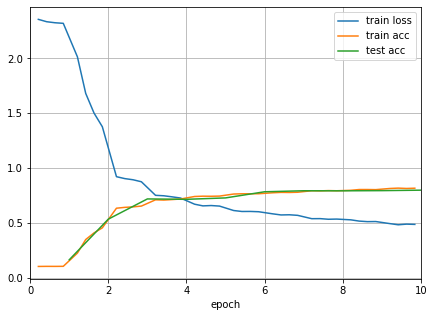

In [36]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

##### Summary
+ A `ConvNet` is a network that employs convolutional layers.
+ In a `ConvNet`, we interleave convolutions, nonlinearities, and (often) pooling operations.
+ These convolutional blocks are typically arranged so that they gradually decrease the spatial resolution of the representations, while increasing the number of channels.
+ In traditional `ConvNets`, the representations encoded by the convolutional blocks are processed by one (or more) dense layers prior to emitting output.
+ `LeNet` was arguably the first successful deployment of such a network.

##### Exercises
1. Replace the average pooling with max pooling. What happens?
2. Try to construct a more complex network based on LeNet to improve its accuracy.
    + Adjust the convolution window size.
    + Adjust the number of output channels.
    + Adjust the activation function (ReLU?).
    + Adjust the number of convolution layers.
    + Adjust the number of fully connected layers.
    + Adjust the learning rates and other training details (initialization, epochs, etc.)
3. Try out the improved network on the original MNIST dataset.
4. Display the activations of the first and second layer of LeNet for different inputs (e.g., sweaters, coats).